# LangGraph Example: LLM with Tools
This Notebook uses an efficient tool calling approach that allows for parallel tool calling

### Notebook setup

In [1]:
# %pip install --upgrade langchain langsmith langgraph langchain_openai

In [2]:
import openmeteo_requests
import requests_cache
import pandas as pd
from retry_requests import retry
from geopy.geocoders import Nominatim
from geopy.distance import geodesic
from datetime import datetime, timedelta
import requests
import json

In [3]:
from dotenv import load_dotenv
import os

# Load .env file
load_dotenv()

# Get OpenAI keys from .env file
os.environ["OPENAI_API_KEY"] = os.getenv("OPENAI_API_KEY")

# Initialize LangSmith
os.environ["LANGCHAIN_TRACING_V2"] = "true"
os.environ["LANGCHAIN_ENDPOINT"] = "https://api.smith.langchain.com"
os.environ["LANGCHAIN_API_KEY"] = os.getenv("LANGCHAIN_API_KEY")
os.environ["LANGCHAIN_PROJECT"] = "Demos"

# Initialize OpenWeatherMap
OPENWEATHERMAP_API_KEY = os.getenv("OPENWEATHERMAP_API_KEY")

## Set Up SQLite Database

In [4]:
import sqlite3

# Initialize SQLite database
conn = sqlite3.connect('api_data.db')
cursor = conn.cursor()

# Create tables for storing weather and electricity price data
cursor.execute('''
CREATE TABLE IF NOT EXISTS weather_data (
    city TEXT,
    state TEXT,
    date_query TEXT,
    date TEXT,
    temperature REAL
)
''')

cursor.execute('''
CREATE TABLE IF NOT EXISTS electricity_data (
    city TEXT,
    state TEXT,
    date_query TEXT,
    date TEXT,
    price REAL
)
''')

conn.commit()

### Set up the Tools


In [5]:
# Import things that are needed generically for tools
from langchain.pydantic_v1 import BaseModel, Field
from langchain.tools import StructuredTool

In [6]:
REGIONS = {
    "NO1": ("Oslo", (59.9139, 10.7522)),
    "NO2": ("Kristiansand", (58.1467, 7.9956)),
    "NO3": ("Trondheim", (63.4305, 10.3951)),
    "NO4": ("Tromsø", (69.6492, 18.9553)),
    "NO5": ("Bergen", (60.3928, 5.3221)),
}

class ElectricityPriceRequest(BaseModel):
    city: str = Field(description="City")
    state: str = Field(description="State or region")
    date_query: str = Field(description="Date query")

def get_coordinates(city_name: str, state: str) -> tuple:
    geolocator = Nominatim(user_agent="electricity_price_api")
    location = geolocator.geocode(f"{city_name}, {state}")
    if location:
        return location.latitude, location.longitude
    else:
        return None

def find_nearest_region(lat: float, lon: float) -> str:
    min_distance = float("inf")
    nearest_region = None
    for region, (city, coordinates) in REGIONS.items():
        distance = geodesic((lat, lon), coordinates).kilometers
        if distance < min_distance:
            min_distance = distance
            nearest_region = region
    return nearest_region

def fetch_electricity_prices(year: str, month: str, day: str, region: str) -> str:
    url = f"https://www.hvakosterstrommen.no/api/v1/prices/{year}/{month}-{day}_{region}.json"
    response = requests.get(url)
    if response.status_code == 200:
        return json.dumps(response.json(), indent=4)
    else:
        return f"Error fetching data: {response.status_code}"

def get_electricity_prices(city: str, state: str, date_query: str):
    coordinates = get_coordinates(city, state)
    if not coordinates:
        return {"error": "City not found"}
    
    lat, lon = coordinates
    end_date = datetime.now().strftime("%Y-%m-%d")
    
    if date_query.lower() == "today":
        start_date = end_date
    elif date_query.lower() == "yesterday":
        start_date = (datetime.now() - timedelta(1)).strftime("%Y-%m-%d")
        end_date = start_date
    elif "last" in date_query.lower():
        if "10 days" in date_query.lower():
            start_date = (datetime.now() - timedelta(10)).strftime("%Y-%m-%d")
        elif "30 days" in date_query.lower():
            start_date = (datetime.now() - timedelta(30)).strftime("%Y-%m-%d")
        elif "three months" in date_query.lower():
            start_date = (datetime.now() - timedelta(90)).strftime("%Y-%m-%d")
        else:
            return {"error": "Invalid date query"}
    else:
        try:
            start_date, end_date = date_query.split('/')
            datetime.strptime(start_date, "%Y-%m-%d")
            datetime.strptime(end_date, "%Y-%m-%d")
        except ValueError:
            return {"error": "Invalid date format. Use YYYY-MM-DD or predefined ranges."}

    nearest_region = find_nearest_region(lat, lon)
    if nearest_region:
        prices = fetch_electricity_prices(start_date[:4], start_date[5:7], start_date[8:10], nearest_region)
        return prices
    else:
        return "Could not determine the nearest region."

electricity_tool = StructuredTool.from_function(
    func=get_electricity_prices,
    name="Fetch_Electricity_Prices",
    description="Fetch electricity prices from a specified city and state, with a date query",
    args_schema=ElectricityPriceRequest,
    return_direct=False,
)


In [7]:
class WebSearchRequest(BaseModel):
    input: str = Field(description="Search query")

def web_search(input: str) -> str:
    """Runs web search."""
    web_search_tool = TavilySearchResults()
    docs = web_search_tool.invoke({"query": input})
    return docs

web_search_tool = StructuredTool.from_function(
    func=web_search,
    name="Web_Search",
    description="Runs a web search",
    args_schema=WebSearchRequest,
    return_direct=False,
)

## Weather tool

In [8]:
class WeatherRequest(BaseModel):
    city: str = Field(description="City")
    state: str = Field(description="State or region")
    date_query: str = Field(description="Date query")

def get_coordinates(city_name: str, state: str) -> tuple:
    geolocator = Nominatim(user_agent="weather_api")
    location = geolocator.geocode(f"{city_name}, {state}")
    if location:
        return location.latitude, location.longitude
    else:
        return None

def fetch_weather_data(city: str, state: str, date_query: str):
    coordinates = get_coordinates(city, state)
    if not coordinates:
        return {"error": "City not found"}
    
    lat, lon = coordinates
    end_date = datetime.now().strftime("%Y-%m-%d")
    
    if date_query.lower() == "today":
        start_date = end_date
    elif date_query.lower() == "yesterday":
        start_date = (datetime.now() - timedelta(1)).strftime("%Y-%m-%d")
        end_date = start_date
    elif "last" in date_query.lower():
        if "10 days" in date_query.lower():
            start_date = (datetime.now() - timedelta(10)).strftime("%Y-%m-%d")
        elif "30 days" in date_query.lower():
            start_date = (datetime.now() - timedelta(30)).strftime("%Y-%m-%d")
        elif "three months" in date_query.lower():
            start_date = (datetime.now() - timedelta(90)).strftime("%Y-%m-%d")
        else:
            return {"error": "Invalid date query"}
    else:
        try:
            start_date, end_date = date_query.split('/')
            datetime.strptime(start_date, "%Y-%m-%d")
            datetime.strptime(end_date, "%Y-%m-%d")
        except ValueError:
            return {"error": "Invalid date format. Use YYYY-MM-DD or predefined ranges."}

    cache_session = requests_cache.CachedSession('.cache', expire_after=-1)
    retry_session = retry(cache_session, retries=5, backoff_factor=0.2)
    openmeteo = openmeteo_requests.Client(session=retry_session)

    url = "https://archive-api.open-meteo.com/v1/archive"
    params = {
        "latitude": lat,
        "longitude": lon,
        "start_date": start_date,
        "end_date": end_date,
        "hourly": "temperature_2m"
    }

    responses = openmeteo.weather_api(url, params=params)
    response = responses[0]

    location_info = {
        "Coordinates": f"{response.Latitude()}°N {response.Longitude()}°E",
        "Elevation": f"{response.Elevation()} m asl",
        "Timezone": f"{response.Timezone()} {response.TimezoneAbbreviation()}",
        "Timezone difference to GMT+0": f"{response.UtcOffsetSeconds()} s"
    }

    hourly = response.Hourly()
    hourly_temperature_2m = hourly.Variables(0).ValuesAsNumpy()
    time_indices = list(range(0, len(hourly_temperature_2m), 6))
    hourly_temperature_2m_6hr = hourly_temperature_2m[time_indices]

    hourly_data = {
        "date": pd.date_range(
            start=pd.to_datetime(hourly.Time(), unit="s", utc=True),
            periods=len(hourly_temperature_2m_6hr),
            freq='6H'
        ),
        "temperature_2m": hourly_temperature_2m_6hr
    }

    hourly_dataframe = pd.DataFrame(data=hourly_data)

    return location_info, hourly_dataframe

weather_tool = StructuredTool.from_function(
    func=fetch_weather_data,
    name="Fetch_Weather_Data",
    description="Fetch weather data from a specified city and state, with a date query",
    args_schema=WeatherRequest,
    return_direct=False,
)


In [ ]:
# Example usage
request = ElectricityPriceRequest(year="2024", month="08", day="06", city="Oslo", state="Oslo")
print(get_electricity_prices(request))

In [9]:
class DifferenceInput(BaseModel):
    minuend: int = Field(
        description="The number from which another number is to be subtracted"
    )
    subtrahend: int = Field(description="The number to be subtracted")


def get_difference(minuend: int, subtrahend: int) -> int:
    return minuend - subtrahend


difference_tool = StructuredTool.from_function(
    func=get_difference,
    name="Difference",
    description="Get the difference between two numbers",
    args_schema=DifferenceInput,
    return_direct=False,
)

### Set up the agent


In [10]:
from langchain_openai import ChatOpenAI

# Create the OpenAI LLM
llm = ChatOpenAI(model="gpt-3.5-turbo-1106", temperature=0, streaming=True)

In [11]:
# Set up the tools to execute them from the graph
from langgraph.prebuilt import ToolExecutor

tools = [weather_tool, difference_tool, electricity_tool, web_search_tool]

executor = ToolExecutor(tools)


In [12]:
from pydantic import BaseModel, Field

class Response(BaseModel):
    electricity_prices: str = Field(description="Electricity prices for the specified query")
    real_time_info: str = Field(description="Real-time information fetched via web search")
#    sql_query_result: str = Field(description="Result from executing the SQL query on the database")
#   weather_data: str = Field()


In [13]:
from langchain_openai import ChatOpenAI
from langchain_core.utils.function_calling import convert_to_openai_function

from langchain_core.prompts import (
    ChatPromptTemplate,
    MessagesPlaceholder,
)
from langchain_core.runnables import RunnablePassthrough

prompt = ChatPromptTemplate.from_messages(
    [
        (
            "system",
            "You are a helpful assistant",
        ),
        MessagesPlaceholder(variable_name="messages", optional=True),
    ]
)



# Create the tools to bind to the model
tools = [convert_to_openai_function(t) for t in tools]
tools.append(convert_to_openai_function(Response))

# MODFIICATION: we're using bind_tools instead of bind_function
model = {"messages": RunnablePassthrough()} | prompt | llm.bind_tools(tools)

### Set up the Agent State

Everything from here onwards is new


In [14]:
from typing import TypedDict, Annotated, Sequence
import operator
from langchain_core.messages import BaseMessage


class AgentState(TypedDict):
    messages: Sequence[BaseMessage]

### Set up the node actions


In [15]:
from langgraph.prebuilt import ToolInvocation
import json
from langchain_core.messages import ToolMessage


def should_continue(state):
    last_message = state["messages"][-1]
    if "tool_calls" not in last_message.additional_kwargs:
        return "end"
    elif any(tool_call["function"]["name"] == "Response" for tool_call in last_message.additional_kwargs["tool_calls"]):
        return "end"
    else:
        return "continue"

def call_model(state):
    messages = state["messages"]
    response = model.invoke(messages)
    return {"messages": messages + [response]}

def call_tool(state):
    messages = state["messages"]
    last_message = messages[-1]
    for tool_call in last_message.additional_kwargs["tool_calls"]:
        action = ToolInvocation(
            tool=tool_call["function"]["name"],
            tool_input=json.loads(tool_call["function"]["arguments"]),
            id=tool_call["id"],
        )
        try:
            response = tool_executor.invoke(action)
            function_message = ToolMessage(
                content=str(response), name=action.tool, tool_call_id=tool_call["id"]
            )
        except Exception as e:
            function_message = ToolMessage(
                content=f"Error: {repr(e)}", name=action.tool, tool_call_id=tool_call["id"]
            )
        messages.append(function_message)
    return {"messages": messages}


### Define the Graph


In [16]:
from langgraph.graph import StateGraph, END

# Initialize a new graph
graph = StateGraph(AgentState)

# Define the two Nodes we will cycle between
graph.add_node("agent", call_model)
graph.add_node("action", call_tool)

# Set the Starting Edge
graph.set_entry_point("agent")

# Set our Contitional Edges
graph.add_conditional_edges(
    "agent",
    should_continue,
    {
        "continue": "action",
        "end": END,
    },
)

# Set the Normal Edges
graph.add_edge("action", "agent")

# Compile the workflow
app = graph.compile()

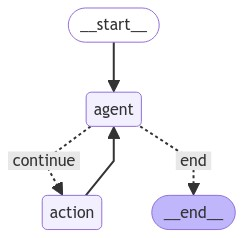

In [17]:
from IPython.display import Image, display

try:
    display(Image(app.get_graph(xray=True).draw_mermaid_png()))
except Exception as e:
    print(f"Failed to display graph: {e}")

### Run our graph


In [18]:
import threading
import uuid
from langchain_core.messages import HumanMessage, AIMessage, ToolMessage
from langgraph.graph import StateGraph
from langgraph.prebuilt import ToolNode
import threading
import uuid
from langchain_core.messages import HumanMessage, AIMessage, ToolMessage

final_output = {"content": "", "tool_calls": []}

def _print_event(event, printed_set, max_length=1500):
    current_state = event.get("dialog_state")
    if current_state:
        print(f"Currently in: ", current_state[-1])
    message = event.get("messages")
    if message:
        if isinstance(message, list):
            message = message[-1]
        if message.id not in printed_set:
            msg_repr = message.pretty_repr(html=True)
            if len(msg_repr) > max_length:
                msg_repr = msg_repr[:max_length] + " ... (truncated)"
            print(msg_repr)
            printed_set.add(message.id)
            if isinstance(message, AIMessage):
                final_output["content"] = message.content
                final_output["tool_calls"] = message.additional_kwargs.get("tool_calls", [])

def handle_tool_error(state) -> dict:
    error = state.get("error")
    tool_calls = state["messages"][-1].tool_calls
    return {
        "messages": [
            ToolMessage(
                content=f"Error: {repr(error)}\n please fix your mistakes.",
                tool_call_id=tc["id"]
            ) for tc in tool_calls
        ]
    }

def stream_events(question, config):
    events = app.stream(
        {"messages": [HumanMessage(content=question)]}, config, stream_mode="values"
    )
    for event in events:
        _print_event(event, _printed)

def process_question(question, config):
    stream_events(question, config)


In [19]:
# Setup threading and configuration
questions = [
    "What is magic_function(3)",
    "What was the weather at Lillehammer yesterday? Are the electricityprices correlated with the weather?",
    "Was it warmer in Lillehammer than Hamar yesterday?"
]

_printed = set()
thread_id = str(uuid.uuid4())

config = {
    "configurable": {
        "thread_id": thread_id,  # Checkpoints are accessed by thread_id
    }
}

# Start the thread
thread = threading.Thread(target=process_question, args=(questions[1], config))
thread.start()

# Wait for the thread to complete
thread.join()

# Access the final output
print("Final Output Content:", final_output["content"])
print("Tool Calls:", final_output["tool_calls"])

================================ Human Message =================================

What was the weather at Lillehammer yesterday? Are the electricityprices correlated with the weather?


Exception in thread Thread-4 (process_question):
Traceback (most recent call last):
  File "/usr/lib/python3.11/threading.py", line 1045, in _bootstrap_inner
    self.run()
  File "/home/teodorrk/Projects/Langchain_agent/.myvenv/lib/python3.11/site-packages/ipykernel/ipkernel.py", line 766, in run_closure
    _threading_Thread_run(self)
  File "/usr/lib/python3.11/threading.py", line 982, in run
    self._target(*self._args, **self._kwargs)
  File "/tmp/ipykernel_200663/1280444440.py", line 50, in process_question
  File "/tmp/ipykernel_200663/1280444440.py", line 46, in stream_events
  File "/home/teodorrk/Projects/Langchain_agent/.myvenv/lib/python3.11/site-packages/langgraph/pregel/__init__.py", line 1110, in stream
    _panic_or_proceed(done, inflight, step)
  File "/home/teodorrk/Projects/Langchain_agent/.myvenv/lib/python3.11/site-packages/langgraph/pregel/__init__.py", line 1780, in _panic_or_proceed
    raise exc
  File "/usr/lib/python3.11/concurrent/futures/thread.py", line 5

Final Output Content: 
Tool Calls: []
